In [ ]:
import torch
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Carrega nomes em um vetor chamado words
words = open('nomes-br-populares.csv', 'r').read().splitlines()

#lista os 8 primeiros
words[:8]

['AANA', 'AANTONIO', 'AARAO', 'AARON', 'ABADIA', 'ABADIO', 'ABDA', 'ABDALA']

In [ ]:
# Total de nomes
len(words)

18960

In [ ]:
# Cria um mapa de caracteres para o alfabeto usado nos nomes, e um "." como caractere especial 
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'A', 2: 'B', 3: 'C', 4: 'D', 5: 'E', 6: 'F', 7: 'G', 8: 'H', 9: 'I', 10: 'J', 11: 'K', 12: 'L', 13: 'M', 14: 'N', 15: 'O', 16: 'P', 17: 'Q', 18: 'R', 19: 'S', 20: 'T', 21: 'U', 22: 'V', 23: 'W', 24: 'X', 25: 'Y', 26: 'Z', 0: '.'}


In [ ]:
## Cria os conjuntos de validação, teste e treino
# build the dataset
block_size = 3 # Tamanho da janela de contexto

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([118341, 3]) torch.Size([118341])
torch.Size([14847, 3]) torch.Size([14847])
torch.Size([14766, 3]) torch.Size([14766])


In [ ]:
# Cria os parametros, embeddings, matriz de incorporação, pesos e viéses
g = torch.Generator().manual_seed(2147483647) # Cria um gerador de números aleatórios (torch.Generator) com uma semente fixa (2147483647),
    ##para que a inicialização seja determinística (os mesmos pesos sempre que rodar).
C = torch.randn((27, 10), generator=g) # Matriz de incorporação
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [ ]:
# Total de parametros de nossa rede neural
sum(p.nelement() for p in parameters)

11897

In [ ]:
# Diz ao PyTorch que todos esses tensores precisam acumular gradientes durante o backpropagation, para que sejam treináveis.
for p in parameters:
  p.requires_grad = True

In [ ]:
# Busca da melhor taxa de treinamento no intervalo
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

# Rastreio da perda durante o treinamento
lri = []
lossi = []
stepi = []

In [ ]:
for i in range(200000):
  
  # constroí os mini lotes
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # Passo pra frente da rede
  emb = C[Xtr[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])

  # Passo pra trás
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # Atualização dos gradientes
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # Rastreio de métricas, passo/perda
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

print(loss.item())

2.2967824935913086


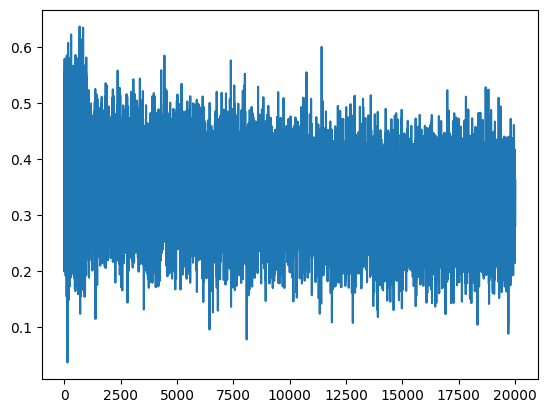

In [ ]:
# Plota a perca em cada mininacth durante o treinamento
plt.plot(stepi, lossi)

In [ ]:
# Validação da perda no conjunto de validação
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1454, grad_fn=<NllLossBackward0>)

In [ ]:
# Validação da perda no conjunto de teste
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(1.8787, grad_fn=<NllLossBackward0>)

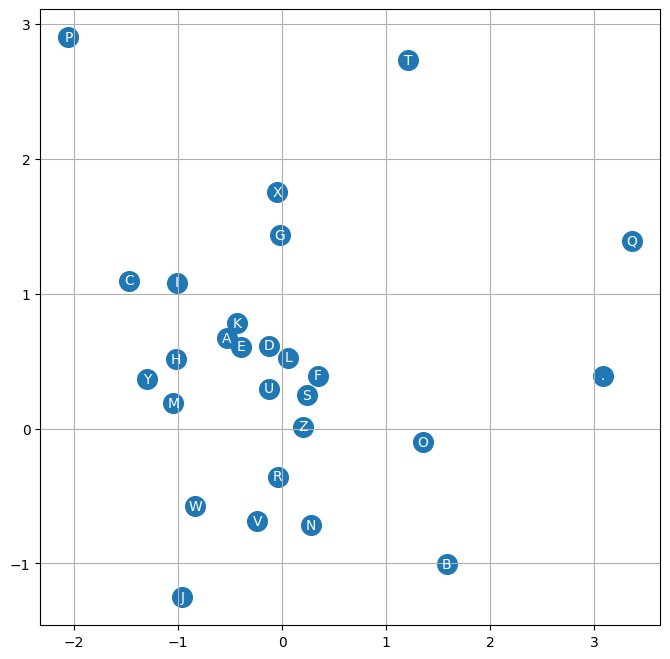

In [ ]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [ ]:
# Amostragem de nomes
# O código simula a escrita de um nome letra por letra, usando as probabilidades previstas pela rede, até encontrar um token de fim (0).
# Ele repete isso 20 vezes para gerar 20 nomes diferentes.

g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

CARMANO.
ALBERVINCIMRITALITA.
SALANE.
EDINO.
ELDA.
ERVAL.
VANEI.
NELMARA.
CLAIIN.
ESLEI.
PHELMO.
DINE.
DIJANI.
LINEI.
VANIQUI.
JERFE.
JARINI.
FRANCISCRLI.
EDIELI.
ABETY.
